# Import dataset and packages

In [2]:
#Import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
transaction=pd.read_csv('C:/Users/YufeiLu/Downloads/TRANSACTION_TAKEHOME.csv')
transaction.head()

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,


In [3]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RECEIPT_ID      50000 non-null  object 
 1   PURCHASE_DATE   50000 non-null  object 
 2   SCAN_DATE       50000 non-null  object 
 3   STORE_NAME      50000 non-null  object 
 4   USER_ID         50000 non-null  object 
 5   BARCODE         44238 non-null  float64
 6   FINAL_QUANTITY  50000 non-null  object 
 7   FINAL_SALE      50000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.1+ MB


# Check data types and convert if necessary

In [4]:
# Convert IDs to string.
transaction['BARCODE']=transaction['BARCODE'].astype(str)
transaction['RECEIPT_ID']=transaction['RECEIPT_ID'].astype(str)
transaction['USER_ID']=transaction['USER_ID'].astype(str)
# Convert Dates to datetime.
transaction['PURCHASE_DATE'] = pd.to_datetime(transaction['PURCHASE_DATE'])
transaction['SCAN_DATE'] = pd.to_datetime(transaction['SCAN_DATE'])

# Check Final Quantity and Final Sale first
Saw some empty values in final_sale and 'zero' in final_quantity

In [5]:
# There're some empty values according to previous code, make sure we can detect every missing value.
transaction['FINAL_SALE'] = transaction['FINAL_SALE'].replace('', np.nan).replace(r'^\s*$', np.nan, regex=True)

In [6]:
transaction['FINAL_SALE']=transaction['FINAL_SALE'].astype(float)

In [7]:
# There're some 'zero' in final quantity, check the unique value and percentage and change to numbers. 
transaction['FINAL_QUANTITY'].value_counts()/len(transaction)

FINAL_QUANTITY
1.00    0.71396
zero    0.25000
2.00    0.02570
3.00    0.00368
4.00    0.00278
         ...   
6.22    0.00002
1.22    0.00002
1.23    0.00002
2.57    0.00002
2.27    0.00002
Name: count, Length: 87, dtype: float64

In [8]:
# Change 'zero' to 0
transaction['FINAL_QUANTITY']=transaction['FINAL_QUANTITY'].replace('zero',0)

In [9]:
transaction['FINAL_QUANTITY']=transaction['FINAL_QUANTITY'].astype(float)

In [10]:
transaction.isnull().sum()
## There're 12500 missing values in Final_Sale. Is it data error, e.g. not loading in right, or does it mean failed transaction? 
## Is it something to do with the Final_Quantity? Should Final_quantity be integer only?

RECEIPT_ID            0
PURCHASE_DATE         0
SCAN_DATE             0
STORE_NAME            0
USER_ID               0
BARCODE               0
FINAL_QUANTITY        0
FINAL_SALE        12500
dtype: int64

In [11]:
# Explore final quantity - should it be integer only?
transaction['quant_numeric'] = pd.to_numeric(transaction['FINAL_QUANTITY'], errors='coerce')
non_integer_count = transaction[~transaction['quant_numeric'].isnull() & (transaction['quant_numeric'] % 1 != 0)].shape[0]
print(f'Non-integer final quantity has {non_integer_count} count, which is {non_integer_count/len(transaction)*100} % of all final quantity')

Non-integer final quantity has 110 count, which is 0.22 % of all final quantity


In [12]:
## Only 0.22% of final quantity (110 count) is non-integer, I'd remove these numbers because it could be some errors.
transaction=transaction[transaction['quant_numeric'].isnull()==0]

In [ ]:
# Don't think non-integer final quantity caused empty final sale because the counts don't match. 

# Check purchase date and scan date
Saw the two dates didn't match from previous code.

In [42]:
# Create a new column that compare the two date fields
transaction['date_same']=(transaction['PURCHASE_DATE'].dt.date==transaction['SCAN_DATE'].dt.date)

In [43]:
# Percentage of whether the two dates match.
transaction['date_same'].value_counts()/len(transaction)
## 52% of the transaction don't have the same purchase date and scan date, which is very concerning. Is there a data lag or error?
## Here I'll use scan date because it has more detailed date information like the specific time.

date_same
False    0.52356
True     0.47644
Name: count, dtype: float64

# Which year has the most transaction?

In [13]:
transaction['SCAN_DATE'].dt.year.value_counts().sort_index()
## This table only has transaction in 2024. Use Month instead.

SCAN_DATE
2024    50000
Name: count, dtype: int64

In [14]:
transaction_per_month=transaction['SCAN_DATE'].dt.month.value_counts().sort_index()
transaction_per_month
## This table only has transaction from June 2024.

SCAN_DATE
6     9454
7    18774
8    17252
9     4520
Name: count, dtype: int64

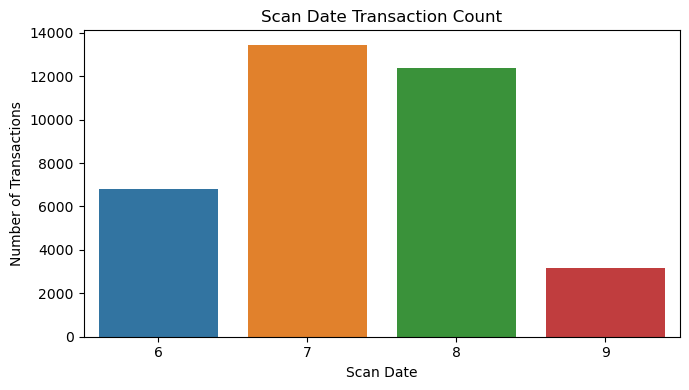

In [103]:
plt.figure(figsize=(7, 4))
sns.barplot(x=transaction_per_month.index,y=transaction_per_month.values)
plt.title('Scan Date Transaction Count')
plt.xlabel('Scan Date')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()
## July and August are higher than the other two months. May need more data to decide if there's a seasonality.

# Check duplicated value

In [12]:
transaction.duplicated().sum()
## Drop duplicates

171

In [76]:
transaction=transaction.drop_duplicates()

# Examine categorical variable

In [21]:
store_pct=transaction['STORE_NAME'].value_counts()/len(transaction)*100
store_pct
## 42% of the transaction were in Walmart.

STORE_NAME
WALMART                   42.652
DOLLAR GENERAL STORE       5.496
ALDI                       5.280
KROGER                     2.988
TARGET                     2.968
                           ...  
SPIRITS                    0.004
LA GLORIA SUPERMERCADO     0.004
FARM FRESH                 0.004
ALTA                       0.004
PLATEAU TRAVEL CENTER      0.004
Name: count, Length: 954, dtype: float64

C:\Users\YufeiLu\AppData\Local\Temp\ipykernel_11232\3894892508.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(index, value + 1, f"{top5_storepct['Percentage'][index]:.1f}%", ha='center')


(0.0, 47.652)

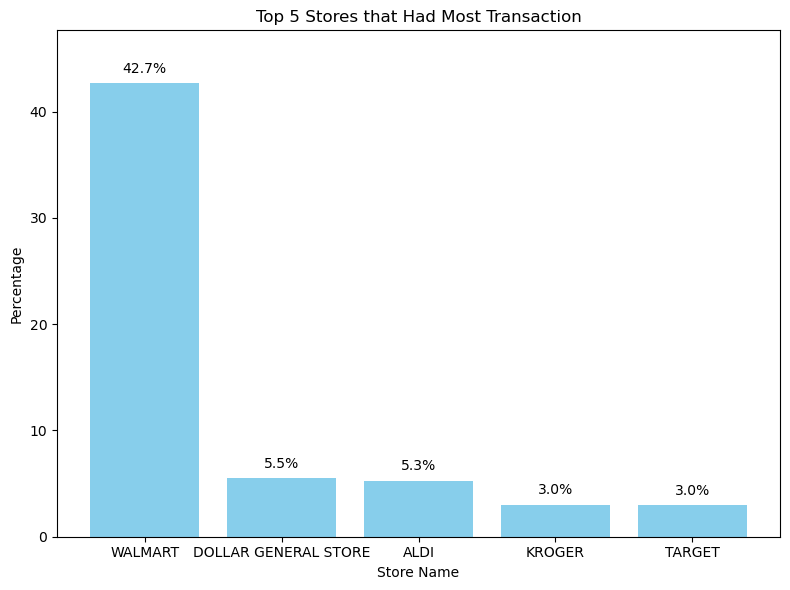

In [23]:
# Convert to dataframe
store_pct=pd.DataFrame(store_pct)
store_pct.columns=['Percentage']
# Data Visualization to show top 5 categories
top5_storepct=store_pct.nlargest(5,'Percentage') # Get top 5 categories
plt.figure(figsize=(8,6))
plt.bar(top5_storepct.index, top5_storepct['Percentage'], color='skyblue') # Bar chart

for index, value in enumerate(top5_storepct['Percentage']):
    plt.text(index, value + 1, f"{top5_storepct['Percentage'][index]:.1f}%", ha='center')

plt.xlabel('Store Name')
plt.ylabel('Percentage')
plt.title('Top 5 Stores that Had Most Transaction')
plt.tight_layout()
plt.ylim(0, top5_storepct['Percentage'].max() + 5)

## 42.7% transaction was scanned in Walmart. It is the most leading store.

# Check outliers in numercal variables

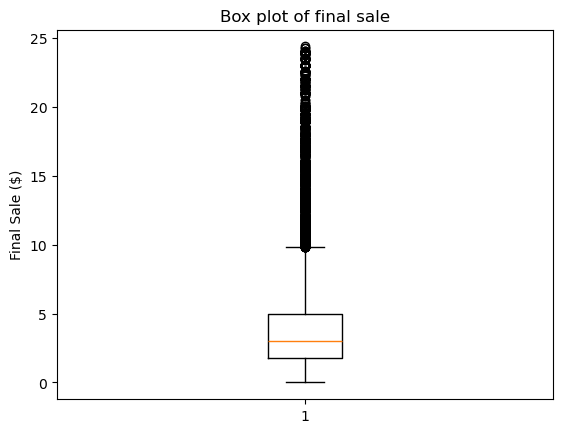

In [79]:
# Check final sale
plt.boxplot(transaction['FINAL_SALE'].dropna())
plt.title('Box plot of final sale')
plt.ylabel('Final Sale ($)')
plt.show()
## Can set arbitrary percentile to remove outliers based on domain knowledge, but here I'll use 3 standard deviation to remove outliers. 

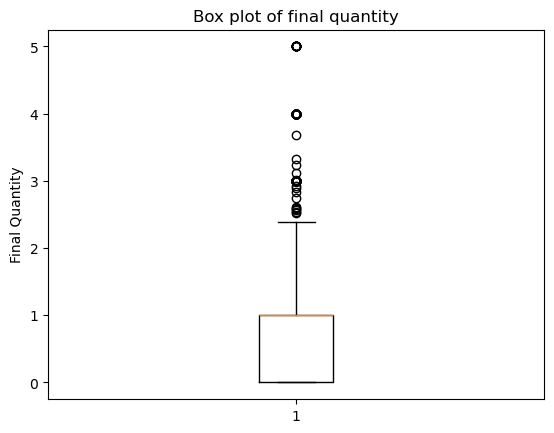

In [71]:
# Check final quantity
plt.boxplot(transaction['FINAL_QUANTITY'].dropna())
plt.title('Box plot of final quantity')
plt.ylabel('Final Quantity')
plt.show()
## Also use 3 standard deviation to remove outliers.

In [80]:
# Create function to get the lower and upper bound for outliers.
def outlier_bound (df,col) :
    mean = df[col].mean()
    std = df[col].std()
    lower_bound=mean-3*std
    upper_bound=mean+3*std
    return lower_bound, upper_bound

In [81]:
# Double check the bound for final_sale
outlier_bound(transaction,'FINAL_SALE')
# It doesn't make sense that final sale has negative number, so I will use 0 as the lower bound.

(-6.932490231358178, 15.307034946805333)

In [82]:
# Remove outliers based on final_sale.
transaction=transaction[(transaction['FINAL_SALE']>=0) & 
(transaction['FINAL_SALE']<=outlier_bound(transaction,'FINAL_SALE')[1])]

In [83]:
# Double check the bound for final_quantity
outlier_bound(transaction,'FINAL_QUANTITY')
# It doesn't make sense that final quantity has negative number, so I will use 0 as the lower bound.

(-0.9660481874567585, 2.372462097408707)

In [84]:
# Remove outliers based on final_sale.
transaction=transaction[(transaction['FINAL_QUANTITY']>=0) & 
(transaction['FINAL_QUANTITY']<=outlier_bound(transaction,'FINAL_QUANTITY')[1])]

In [72]:
## Notes that we can definitely be bold by setting a lower percentile for outliers once we have more domain context.

# Write cleaned dataframe to csv and save

In [107]:
# Gets the current working directory
original_path = os.getcwd()  

# Write DataFrame to CSV in the original path
transaction.to_csv(os.path.join(original_path, 'transaction.csv'), index=False)

# Insights
1. 42.7% of the transaction were made in Walmart.
2. July transaction count is 1.5 times than June transaction count. However, we do need more data to see if there's a seasonality.
# Issues
1. The data type is not consistent in Final_sale that it shows 'zero' instead of 0.
2. Missing values in final_sale. Need to find out if failed transaction is included or is it because of data ETL problem.
3. 52% of the transaction don't have a matched purchase_date and scan_date. Could it be data lag or some business rule?
4. Small percentage of final_quantity and final_sale have negative numbers. Already removed the outliers. 